In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gseapy as gp
from tqdm import tqdm
from adjustText import adjust_text
import seaborn as sns
import sys

In [2]:
def plot_celltype_distribution(adata, celltype_column, celltype_of_interest, min_cells=100,savefig=None):
    # Filter the data to include only the cell type of interest
    adata_filtered = adata[adata.obs[celltype_column] == celltype_of_interest]
    
    # Group by batchID and Brain_Region to get the count of cells of interest in each region
    filtered_grouped = (
        adata_filtered.obs.groupby(['batchID', 'Brain_Region'])
        .size()
        .reset_index(name='Count')
    )
    
    # Group by batchID and Brain_Region to get the total count of cells in each region
    total_cells_grouped = (
        adata.obs.groupby(['batchID', 'Brain_Region'])
        .size()
        .reset_index(name='Total_Cells')
    )
    
    # Merge the filtered counts with the total cell counts
    merged = pd.merge(filtered_grouped, total_cells_grouped, on=['batchID', 'Brain_Region'])
    
    # Filter out regions with fewer than the specified minimum number of cells
    merged = merged[merged['Total_Cells'] >= min_cells]
    
    # Group by batchID to get the total count of the cell type of interest in each batch
    batch_totals = (
        adata_filtered.obs.groupby('batchID')
        .size()
        .reset_index(name='Batch_Total')
    )
    
    # Merge the data to calculate the percentage of the cell type of interest in each region, normalized by batch total
    merged = pd.merge(merged, batch_totals, on='batchID')
    merged['Percentage'] = (merged['Count'] / merged['Batch_Total']) * 100
    
    # Create a bar plot with a strip plot overlay
    plt.figure(figsize=(12, 8))
    
    # Bar plot showing the percentage of the cell type of interest in each brain region, aggregated across batches
    sns.barplot(data=merged, x='Brain_Region', y='Percentage', ci='sd',capsize=0.11, color=None)
    merged['age'] = merged['batchID'].apply(lambda x: x.split('-')[0])
    
    # Strip plot showing the percentage for each batchID
    merged_young = merged[merged['age'] == '3']
    merged_old = merged[merged['age'] == '24']
    sns.stripplot(data=merged_young, x='Brain_Region', y='Percentage', hue='batchID', dodge=True, jitter=True, size=8, marker='o', edgecolor='gray',color='gray', alpha=1)
    sns.stripplot(data=merged_old, x='Brain_Region', y='Percentage', hue='batchID', dodge=True, jitter=True, size=8, marker='^', edgecolor='black',color='black', alpha=1)
    
    # Customize the plot
    plt.title(f'Percentage of {celltype_of_interest} in Each Brain Region (min {min_cells} cells), normalized by batch')
    plt.ylabel('Percentage of Total in Batch')
    plt.xlabel('Brain Region')
    plt.xticks(rotation=90, ha='center')
    plt.legend(title='Batch ID', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    if savefig == None:
        pass
    else:
        plt.savefig(savefig, format='pdf')
    
    # Show the plot
    plt.show()
    return merged

In [3]:
adata = sc.read_h5ad('../../MERFISH/Baysor/ABC_cleaned.h5ad')
adata_HQ = adata[(adata.obs.subclass_label_confidence > 0.5)]
adata_HQ = adata_HQ[adata_HQ.obs.Brain_Region != 'Unlabeled']

/tmp/ipykernel_828373/587282938.py:7: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_filtered.obs.groupby(['batchID', 'Brain_Region'])
/tmp/ipykernel_828373/587282938.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata.obs.groupby(['batchID', 'Brain_Region'])
/tmp/ipykernel_828373/587282938.py:27: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  adata_filtered.obs.groupby('batchID')
/tmp/ipykernel_828373/5872829

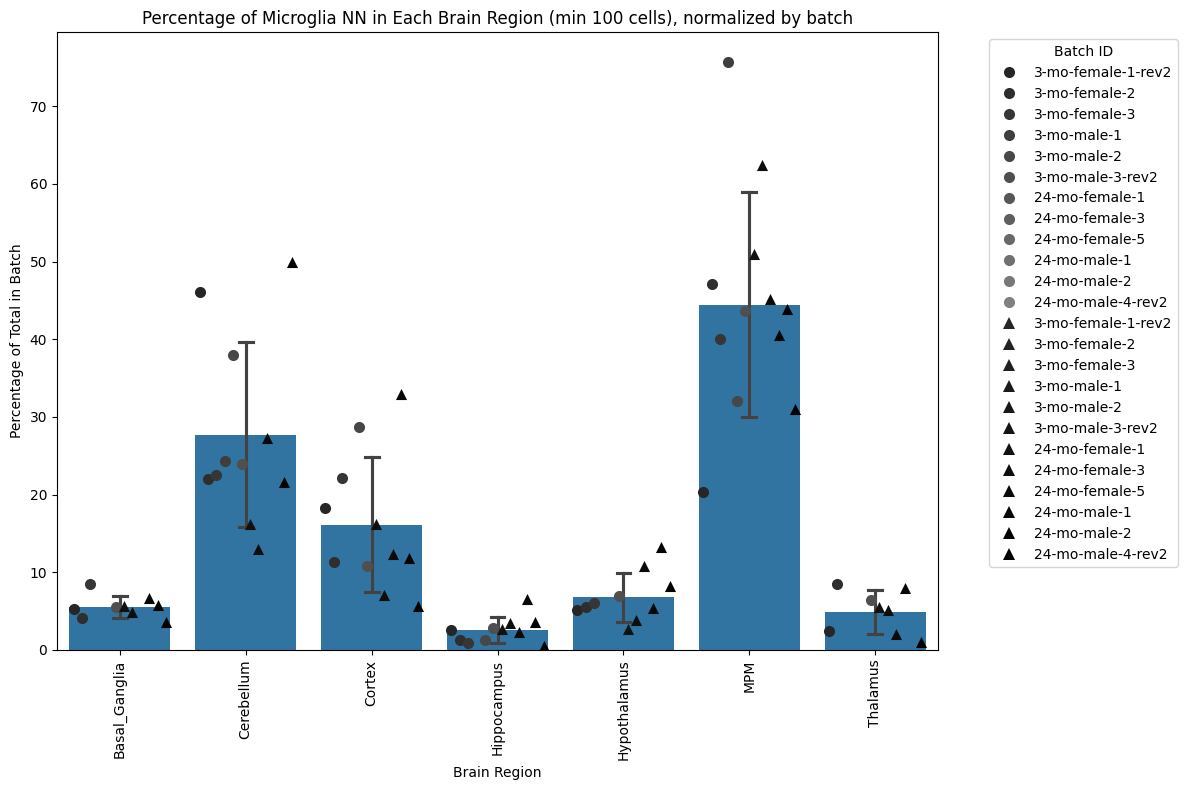

,batchID,Brain_Region,Count,Total_Cells,Batch_Total,Percentage,age
0,3-mo-female-1-rev2,Basal_Ganglia,49,4372,938,5.223881,3
1,3-mo-female-1-rev2,Cerebellum,432,15032,938,46.055437,3
2,3-mo-female-1-rev2,Cortex,171,9371,938,18.230277,3
3,3-mo-female-1-rev2,Hippocampus,24,1578,938,2.558635,3
4,3-mo-female-1-rev2,Hypothalamus,48,3670,938,5.117271,3
...,...,...,...,...,...,...,...
67,24-mo-male-4-rev2,Cortex,41,7234,720,5.694444,24
68,24-mo-male-4-rev2,Hippocampus,4,705,720,0.555556,24
69,24-mo-male-4-rev2,Hypothalamus,59,3299,720,8.194444,24
70,24-mo-male-4-rev2,MPM,223,18660,720,30.972222,24


In [4]:
plot_celltype_distribution(adata_HQ, 'subclass_label_transfer', 'Microglia NN',savefig='figures/Microglia.pdf')

In [5]:
# select even further down for easier visualization, remove the very sparse cell types
adata_HQ = adata_HQ[adata_HQ.obs.adjusted_subclass_label_confidence > 0.5]

cell_type_counts = adata_HQ.obs['subclass_label_transfer'].value_counts()

# Filter the cell types that have more than 1000 cells
cell_types_to_keep = cell_type_counts[cell_type_counts > 1000].index

# Subset the adata object to keep only those cell types
adata_subset = adata_HQ[adata_HQ.obs['subclass_label_transfer'].isin(cell_types_to_keep)].copy()

In [6]:
# find marker genes
sc.tl.rank_genes_groups(adata_subset, groupby='subclass_label_transfer', method='wilcoxon', n_genes=50)
sc.tl.filter_rank_genes_groups(adata_subset,min_fold_change=1,min_in_group_fraction=0.3,max_out_group_fraction=0.5)

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:461: RuntimeWarning: invalid value encountered in log2
  se

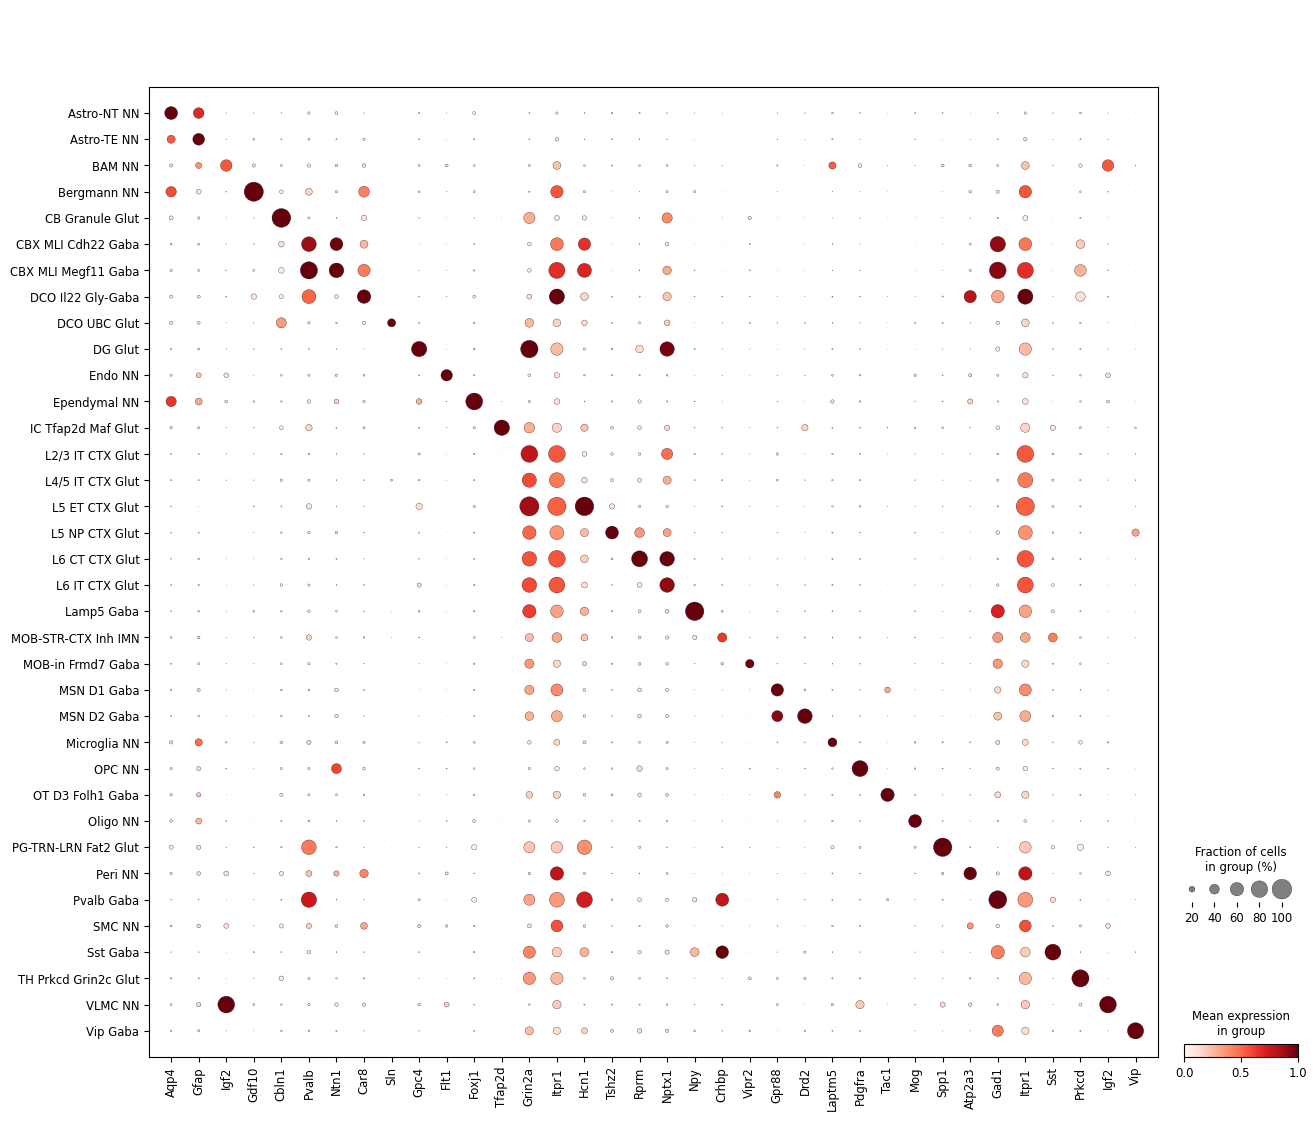

In [7]:
# use the genes which we found from the filter rank genes groups
sc.pl.dotplot(adata_subset, var_names=['Aqp4','Gfap','Igf2','Gdf10','Cbln1','Pvalb','Ntn1','Car8','Sln','Gpc4','Flt1','Foxj1', 'Tfap2d','Grin2a','Itpr1','Hcn1','Tshz2', \
                                  'Rprm','Nptx1','Npy','Crhbp', 'Vipr2','Gpr88','Drd2','Laptm5','Pdgfra','Tac1','Mog','Spp1','Atp2a3', \
                                      'Gad1','Itpr1','Sst','Prkcd','Igf2','Vip'], groupby='subclass_label_transfer', standard_scale='var',save='_full_object_subclass_labels.pdf')

/home/doug.henze/.conda/envs/Vizgen_2/lib/python3.9/site-packages/scanpy/plotting/_utils.py:471: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


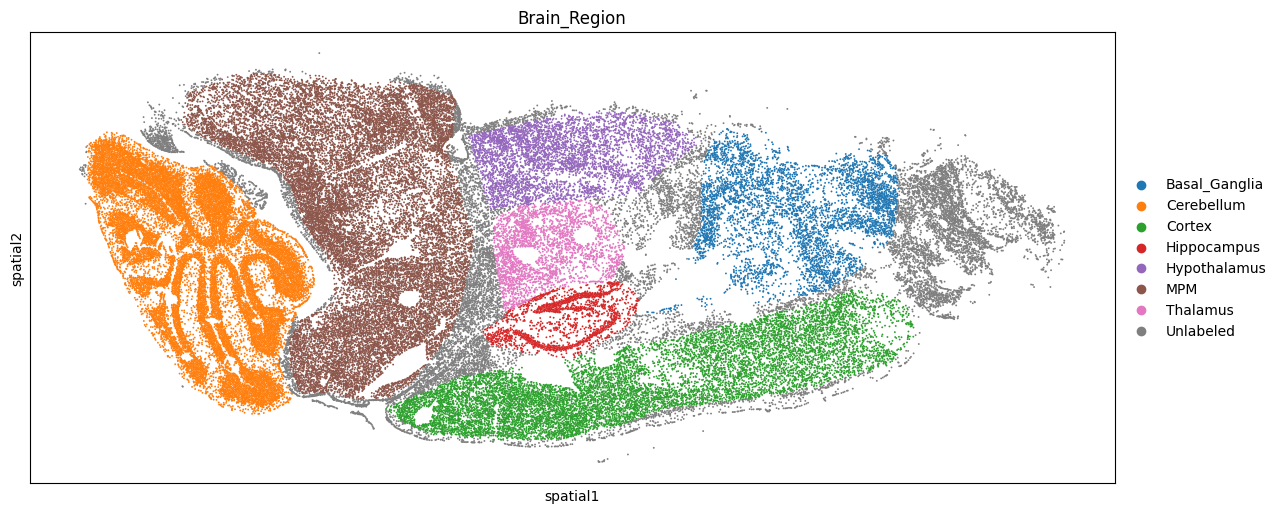

In [8]:
# Visualize the full raw brain
fig, ax = plt.subplots(figsize=(14,14))
sc.pl.spatial(adata[(adata.obs.batchID == '3-mo-female-1-rev2')],color='Brain_Region',spot_size=25,ax=ax)
fig.savefig('figures/spatial_plot_region.pdf', format='pdf')